<a href="https://colab.research.google.com/github/mohitshah3111999/Facial-Expression-Recognition/blob/main/BTP_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from matplotlib import pyplot
from google.colab import drive

import cv2
from google.colab.patches import cv2_imshow
from scipy import ndimage
from keras.applications.mobilenet import MobileNet
from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

In [ ]:
drive.mount("/content/drive")
%cd drive/MyDrive/facial_expression/

Mounted at /content/drive
/content/drive/MyDrive/facial_expression


In [ ]:
train_path = ".//FER2013//train"
test_path = ".//FER2013//test"
val_path = ".//FER2013/validation"

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   zoom_range=0.2)

test_datagen = ImageDataGenerator(rescale=1/255)

batch_size = 128

train_generator = train_datagen.flow_from_directory (train_path,   
                                                     target_size=(48, 48),  
                                                     batch_size=batch_size,
                                                     shuffle=False,
                                                     class_mode='categorical',
                                                     color_mode="rgb")


test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(48,48), 
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical',
                                                  color_mode="rgb")

val_generator = test_datagen.flow_from_directory(val_path,
                                                  target_size=(48,48), 
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical',
                                                  color_mode="rgb")

Found 27742 images belonging to 7 classes.
Found 3542 images belonging to 7 classes.
Found 3544 images belonging to 7 classes.


In [ ]:
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(48,48,3))

# Since we have 7 types of expressions, we'll set the number of classes to 7
num_classes = 7

# Adding some layers to the base_model.
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs= base_model.input, outputs= predictions)

model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 24, 24, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 24, 24, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 24, 24, 32)       128    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
label_to_text = {0: "anger", 1: "disgust", 2: "fear", 3: "happiness", 4: "sadness", 5: "surprise", 6: "neutral"}

In [ ]:
file_name = 'best_model_mobilenet.h5'
checkpoint_path= os.path.join('checkpoint',file_name)

call_back = ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 verbose=1,
                                                 save_freq='epoch',
                                                 save_best_only=True,
                                                 save_weights_only=False,
                                                 mode='max')

# stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)

callbacks_list = [call_back, lr_anneal]

In [ ]:
history = model.fit(train_generator, batch_size=batch_size, epochs=50, validation_data=val_generator, callbacks=callbacks_list)

Epoch 1/50
217/217 [==============================] - ETA: 0s - loss: 1.9047 - accuracy: 0.3314 
Epoch 00001: val_accuracy improved from -inf to 0.37049, saving model to checkpoint/best_model_mobilenet.h5
217/217 [==============================] - 5645s 26s/step - loss: 1.9047 - accuracy: 0.3314 - val_loss: 4.6883 - val_accuracy: 0.3705 - lr: 0.0010
Epoch 2/50
217/217 [==============================] - ETA: 0s - loss: 1.4382 - accuracy: 0.4636
Epoch 00002: val_accuracy improved from 0.37049 to 0.46670, saving model to checkpoint/best_model_mobilenet.h5
217/217 [==============================] - 69s 316ms/step - loss: 1.4382 - accuracy: 0.4636 - val_loss: 2.6867 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 3/50
217/217 [==============================] - ETA: 0s - loss: 1.3104 - accuracy: 0.5096
Epoch 00003: val_accuracy improved from 0.46670 to 0.47686, saving model to checkpoint/best_model_mobilenet.h5
217/217 [==============================] - 68s 315ms/step - loss: 1.3104 - accuracy: 0.

In [ ]:
# Load Model
from keras.models import load_model
import os

%cd checkpoint/
os.listdir()

/content/drive/My Drive/facial_expression/checkpoint


['best_model_mobilenet.h5', 'best_model_custom.h5', 'best_model_resnet.h5']

In [ ]:
import tensorflow_hub as hub

model = load_model("best_model_mobilenet.h5", custom_objects={'KerasLayer':hub.KerasLayer})
model.summary()
%cd ..

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 24, 24, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 24, 24, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 24, 24, 32)       128       
 ation)                                                      

In [ ]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(test_generator)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

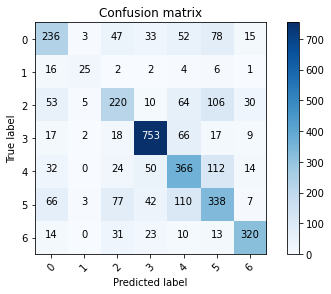

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

Y_true = test_generator.classes
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plot_confusion_matrix(confusion_mtx, classes = range(7))

In [ ]:
score, acc = model.evaluate(test_generator, batch_size=100)
print('Test loss:', score)
print("Test accuracy:", acc)

28/28 [==============================] - 5s 165ms/step - loss: 1.0463 - accuracy: 0.6375
Test score: 1.0463061332702637
Test accuracy: 0.6374929547309875


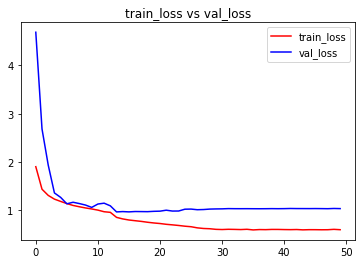

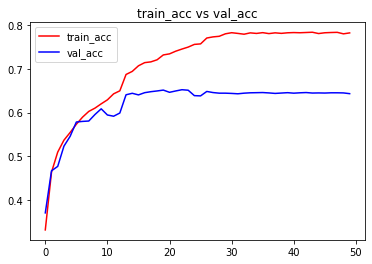

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import pickle

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs, train_loss, 'r', label='train_loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs, train_acc, 'r', label='train_acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()